In [2]:
import cv2 as cv
import numpy as np
from skimage.feature import local_binary_pattern
from scipy.stats import mode
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from sklearn.metrics import accuracy_score , confusion_matrix

In [3]:
image_train=np.load("E:/1-Collage/3-Senior-2/CV/Project/data_set/image_train.npy")
label_train=np.load("E:/1-Collage/3-Senior-2/CV/Project/data_set/label_train.npy")
image_test=np.load("E:/1-Collage/3-Senior-2/CV/Project/data_set/image_test.npy")
label_test=np.load("E:/1-Collage/3-Senior-2/CV/Project/data_set/label_test.npy")

In [4]:
def confusion_image(label_test, y_test_pred, cutoff=1):
    # Step 1: Compute the confusion matrix
    cm = confusion_matrix(label_test, y_test_pred)
    
    # Step 2: Normalize the confusion matrix to range [0, 255]
    cm_normalized = (cm / cm.max()) * 255
    cm_image = Image.fromarray(cm_normalized.astype('uint8'))
    
    # Step 3: Apply contrast stretching
    cm_image = ImageOps.autocontrast(cm_image, cutoff=cutoff)
    
    # Step 4: Plot the confusion matrix
    plt.imshow(cm_image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    # Step 5: Calculate and return accuracy
    accuracy = (cm.diagonal().sum()) / cm.sum()
    print("Accuracy:", accuracy)


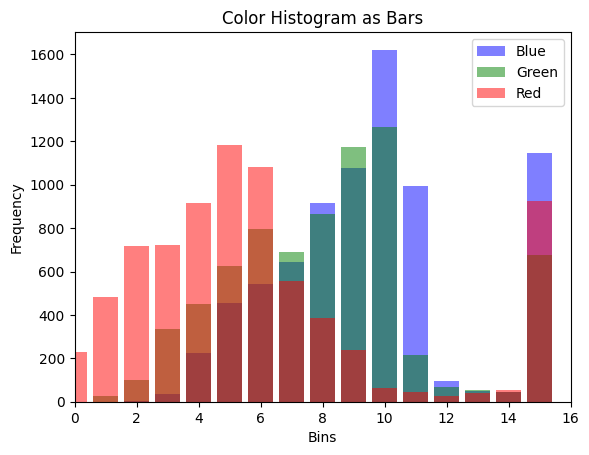

In [5]:
train_b_HG=[]
train_g_HG=[]
train_r_HG=[]
test_b_HG=[]
test_g_HG=[]
test_r_HG=[]

div=16
for image in image_train:
    image_np = np.array(image)
    train_b_HG.append(cv.calcHist([image_np], [2], None, [div], [0, 255]))
    train_g_HG.append(cv.calcHist([image_np], [1], None, [div], [0, 255]))
    train_r_HG.append(cv.calcHist([image_np], [0], None, [div], [0, 255]))

for image in image_test:
    image_np = np.array(image)
    test_b_HG.append(cv.calcHist([image_np], [2], None, [div], [0, 255]))
    test_g_HG.append(cv.calcHist([image_np], [1], None, [div], [0, 255]))
    test_r_HG.append(cv.calcHist([image_np], [0], None, [div], [0, 255]))


train_histograms = [
    np.concatenate((b.flatten(), g.flatten(), r.flatten()))
    for b, g, r in zip(train_b_HG, train_g_HG, train_r_HG)
]
test_histograms = [
    np.concatenate((b.flatten(), g.flatten(), r.flatten()))
    for b, g, r in zip(test_b_HG, test_g_HG, test_r_HG)
]

train_histograms = np.array(train_histograms)
test_histograms = np.array(test_histograms)


plt.xlim([0, div])
img_num = 50


# Plot histogram as usual bars
plt.bar(range(len(train_b_HG[img_num])), train_b_HG[img_num].flatten(), color='b', alpha=0.5, label='Blue')
plt.bar(range(len(train_g_HG[img_num])), train_g_HG[img_num].flatten(), color='g', alpha=0.5, label='Green')
plt.bar(range(len(train_r_HG[img_num])), train_r_HG[img_num].flatten(), color='r', alpha=0.5, label='Red')
plt.title('Color Histogram as Bars')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [6]:
train_histograms_squr = np.sqrt(train_histograms) #adding nonlinearity to the data
test_histograms_squr = np.sqrt(test_histograms)

train_histograms=np.concatenate((train_histograms,train_histograms_squr),axis=1)
test_histograms=np.concatenate((test_histograms,test_histograms_squr),axis=1)


all_data=np.concatenate((train_histograms,test_histograms),axis=0)
mean=np.mean(all_data,axis=0)
std=np.std(all_data,axis=0)

train_histograms=(train_histograms-mean)/std
test_histograms=(test_histograms-mean)/std

label_train = label_train.flatten()
label_test = label_test.flatten()


print(train_histograms.shape)
print(test_histograms.shape)


(70491, 96)
(23619, 96)


In [7]:
def k_means(data, k, max_iters=10000, tol=1e-6):
    
    n_samples, _ = data.shape
    centroids = data[np.random.choice(n_samples, k, replace=False)]
    
    for i in range(max_iters):
        distances = np.linalg.norm(data[:, None, :] - centroids[None, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        error=np.linalg.norm(new_centroids - centroids)

        if error < tol:
            print(error)
            break
        
        centroids = new_centroids

    return labels, centroids


def calculate_cluster_labels(labels_train, label_train, k):
    cluster_labels = np.empty(k, dtype=object)  # Use dtype=object for non-numeric labels

    for i in range(k):
        cluster_indices = np.where(labels_train == i)[0]
        true_labels = label_train[cluster_indices].flatten()

        if len(true_labels) > 0: 
            unique_labels, counts = np.unique(true_labels, return_counts=True)
            cluster_labels[i] = unique_labels[np.argmax(counts)]

    # Map each data point's cluster to its corresponding label
    predicted_labels = np.array([cluster_labels[label] for label in labels_train])

    # Calculate accuracy
    accuracy = np.mean(predicted_labels.flatten() == label_train.flatten())
    
    return cluster_labels, predicted_labels, accuracy


In [9]:
# Run K-Means clustering on the training histograms
k = 141  # Number of clusters
# Check if any element in the label array is an integer
histogram=np.concatenate((train_histograms,test_histograms),axis=0)
label=np.concatenate((label_train,label_test),axis=0)

labels_train, centroids = k_means(histogram, k)

0.0


In [10]:
cluster_labels, y_test_pred_K_mean, accuracy = calculate_cluster_labels(labels_train, label, k)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 77.39%


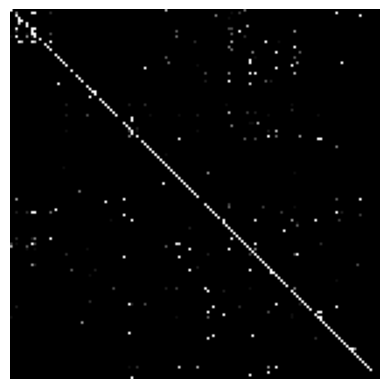

Accuracy: 0.7739241313356711


In [11]:
confusion_image(label, y_test_pred_K_mean)


In [12]:
def knn_predict(X_train, y_train, X_test, k=3):
    predictions = []
    for x_test in X_test:
        # Compute distances to all training points
        distances = np.linalg.norm(X_train - x_test, axis=1)

        # Find the k nearest neighbors
        k_indices = np.argsort(distances)[:k]
        k_labels = y_train[k_indices]

        # Determine the most common label
        unique_labels, counts = np.unique(k_labels, return_counts=True)
        most_common = unique_labels[np.argmax(counts)]
        
        predictions.append(most_common)

    return np.array(predictions)



In [13]:
y_test_pred_KNN = knn_predict(train_histograms, label_train, test_histograms, k=1)  # Use a subset of test data for speed

accuracy = np.mean(y_test_pred_KNN == label_test)  # Match the subset size
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.06%


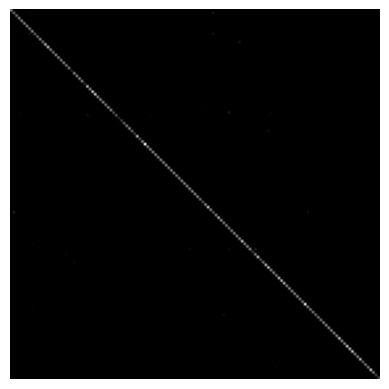

Accuracy: 0.9806088318726449


In [14]:
confusion_image(label_test, y_test_pred_KNN)

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(train_histograms, label_train)


y_test_pred_SVM = svm_model.predict(test_histograms)
print("Test Accuracy:", accuracy_score(label_test, y_test_pred_SVM))


Test Accuracy: 0.9896693340107541


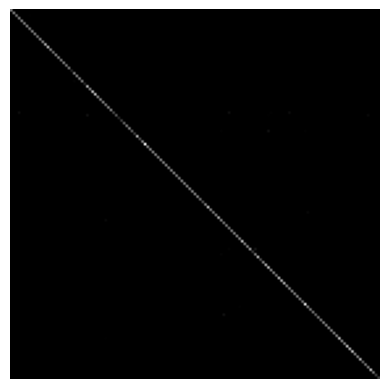

Accuracy: 0.9896693340107541


In [16]:
confusion_image(label_test, y_test_pred_SVM)

True Label: Beetroot 1
SVM Predicted Label: Beetroot 1
KNN Predicted Label: Beetroot 1
K_means Predicted Label: Pineapple 1


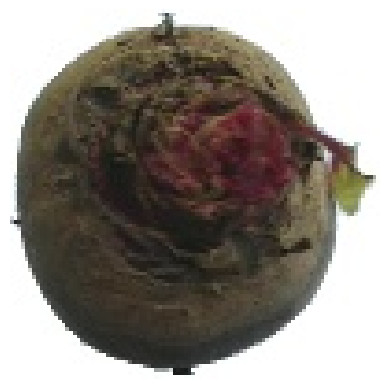

True Label: Plum 1
SVM Predicted Label: Plum 1
KNN Predicted Label: Plum 1
K_means Predicted Label: Plum 1


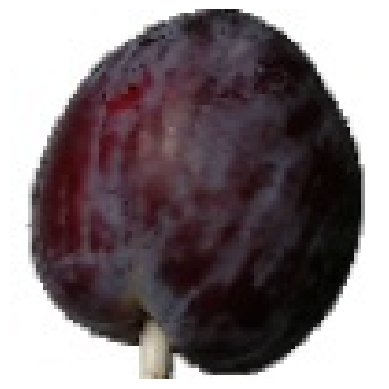

True Label: Peach 2
SVM Predicted Label: Peach 2
KNN Predicted Label: Peach 2
K_means Predicted Label: Peach 2


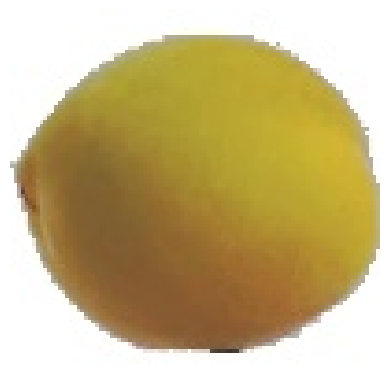

True Label: Grape Pink 1
SVM Predicted Label: Grape Pink 1
KNN Predicted Label: Grape Pink 1
K_means Predicted Label: Grape Pink 1


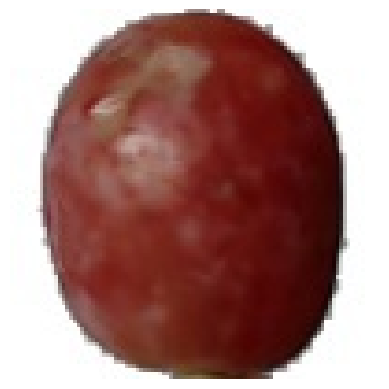

True Label: Cocos 1
SVM Predicted Label: Cocos 1
KNN Predicted Label: Cocos 1
K_means Predicted Label: Cocos 1


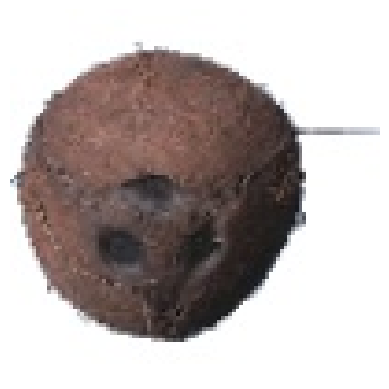

True Label: Guava 1
SVM Predicted Label: Guava 1
KNN Predicted Label: Guava 1
K_means Predicted Label: Guava 1


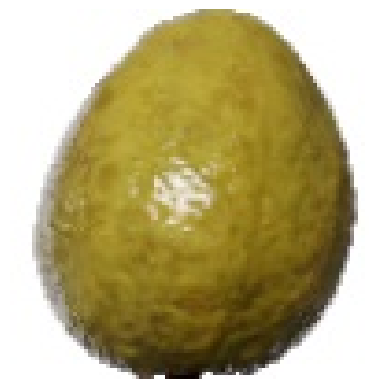

True Label: Pineapple 1
SVM Predicted Label: Pineapple 1
KNN Predicted Label: Pineapple 1
K_means Predicted Label: Melon Piel de Sapo 1


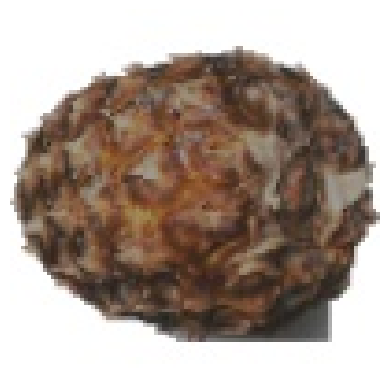

True Label: Quince 1
SVM Predicted Label: Quince 1
KNN Predicted Label: Quince 1
K_means Predicted Label: Quince 1


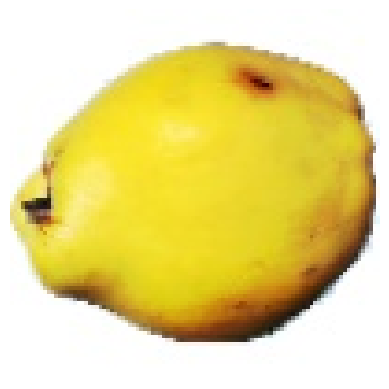

True Label: Pear 1
SVM Predicted Label: Pear 1
KNN Predicted Label: Pear 1
K_means Predicted Label: Apple 6


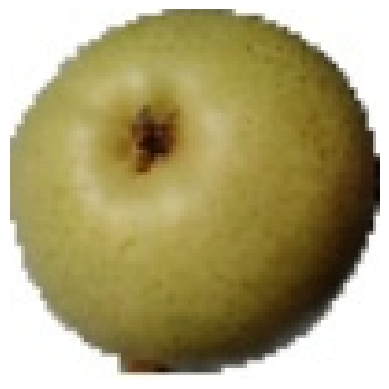

True Label: Pitahaya Red 1
SVM Predicted Label: Pitahaya Red 1
KNN Predicted Label: Pitahaya Red 1
K_means Predicted Label: Pitahaya Red 1


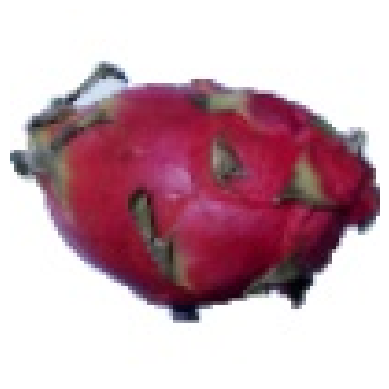

In [17]:
random_array = np.random.randint(0, 20000, size=10)
random_array

for i in range(len(random_array)):
    plt.imshow(image_test[random_array[i],:,:,::-1])
    print("True Label:", label_test[random_array[i]])
    print("SVM Predicted Label:", y_test_pred_SVM[random_array[i]])
    print("KNN Predicted Label:", y_test_pred_KNN[random_array[i]])
    print("K_means Predicted Label:", y_test_pred_K_mean[random_array[i]+70491])
    plt.axis('off')
    plt.show()